In [153]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt
from eeglib.helpers import Helper
import torch

In [154]:
file = pd.read_csv("data/Focus.csv", skiprows=1, 
                    usecols=['EEG.Cz', 'EEG.Fz', 'EEG.Fp1', 'EEG.F7',
                            'EEG.F3', 'EEG.FC1', 'EEG.C3', 'EEG.FC5',
                            'EEG.FT9', 'EEG.T7', 'EEG.CP5', 'EEG.CP1',
                            'EEG.P3', 'EEG.P7', 'EEG.PO9', 'EEG.O1',
                            'EEG.Pz', 'EEG.Oz', 'EEG.O2', 'EEG.PO10',
                            'EEG.P8', 'EEG.P4', 'EEG.CP2', 'EEG.CP6',
                            'EEG.T8', 'EEG.FT10', 'EEG.FC6', 'EEG.C4',
                            'EEG.FC2', 'EEG.F4', 'EEG.F8', 'EEG.Fp2'])
df = pd.DataFrame(file)

In [155]:
def get_mean_electrode(slice, electrode):
    value = 0
    for i in range(slice.shape[0]):
        value += slice[i][electrode]
    return value / slice.shape[0]
        

In [156]:
def rescale_dataset(dataset, scale):
    scaled_set = torch.zeros([(int)(dataset.shape[0] / scale), dataset.shape[1]])
    for i in range(scaled_set.shape[0]):
        slice_of_ten = dataset[(i * scale):(i * scale + scale)]
        for j in range(scaled_set.shape[1]):
            scaled_set[i][j] = get_mean_electrode(slice_of_ten, j)
    return scaled_set

In [157]:
vanilla_data = df.to_numpy()
normalized_data = (vanilla_data - np.min(vanilla_data)) / (np.max(vanilla_data) - np.min(vanilla_data))
standardized_data = normalized_data - normalized_data.mean()
large_data = torch.Tensor(standardized_data)

train_set = rescale_dataset(large_data, 10)

In [158]:
def get_mean_values(dataset):
    mean_values = [0] * dataset.shape[0]
    for i in range(dataset.shape[0]):
        mean_values[i] = dataset[i].mean()
    return mean_values

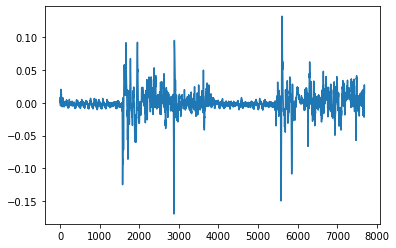

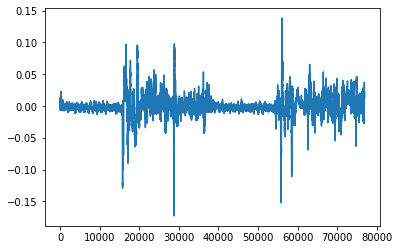

In [159]:
plt.plot(get_mean_values(train_set))
plt.show()
plt.plot(get_mean_values(large_data))
plt.show()

In [160]:
def labelize_set(train_set):
    result = list()
    for index, element in enumerate(train_set):
        if (index < 1500 or (index > 3900 and index < 5400)):
            result.append((element, 0))
        else:
            result.append((element, 1))
    return result
    
labelled_set = labelize_set(train_set)
focusedCount = 0
for signals, labels in labelled_set:
    if (labels == 0):
        focusedCount+=1
focusedCount / train_set.shape[0] * 100

39.01899557637263

In [161]:
random.shuffle(labelled_set)
train_size = (int)(len(labelled_set) * 0.8)
test_size = len(labelled_set) - train_size
train_set = labelled_set[0:train_size]
test_set = labelled_set[train_size:train_size+test_size]

In [162]:
import time
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [163]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # Convolution layer
        self.conv1 = nn.Conv1d(1, 6, 5)
        self.conv2 = nn.Conv1d(6, 16, 5)
        self.max_pool = nn.MaxPool1d(2)
        # --------------------------------

        self.dropout = nn.Dropout(0.25)

        # Fully connected layer
        self.linear1 = nn.Linear(16 * 5, 120)
        self.linear2 = nn.Linear(120, 2)
        # --------------------------------

    def forward(self, x):
        x = x.view(64, 1, 32)
        # Convolution layer
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        # -----------------------

        x = self.dropout(x)

        # Flatten filters
        x = x.view(-1, 16 * 5)

        # Fully connected layer
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        # -------------------------
        return x

In [164]:
network = NeuralNetwork()

LEARNING_RATE = 0.05
EPOCH = 100
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)
# # Load a loss calculator and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=LEARNING_RATE, momentum=0.9)

iteration = 0
start_time = time.time()

train_accuracies = np.zeros(EPOCH)
test_accuracies = np.zeros(EPOCH)

for iteration in range(EPOCH):
    average_loss = 0.0

    print("――――――――――――――――――――――――――――――――――――――――――――――――――")

    # Training
    total = 0
    success = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        try:
            output = network.forward(inputs)
        except:
            continue
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        average_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        success += (predicted == labels.data).sum()
    train_accuracies[iteration] = 100.0 * success / total
    print(train_accuracies[iteration])
    # -------------------------------------------------------------------

    # Testing
    total = 0
    success = 0
    for inputs, labels in tqdm(test_loader):
        try:
            output = network.forward(inputs)
        except:
            continue
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        success += (predicted == labels.data).sum()
    test_accuracies[iteration] = 100.0 * success / total
    # -------------------------------------------------------------------

    print(u"Epoch {}, average loss {}, train accuracy {}, test accuracy {}".format(
        iteration,
        average_loss / len(train_loader),
        train_accuracies[iteration],
        test_accuracies[iteration]
    ))

――――――――――――――――――――――――――――――――――――――――――――――――――
60.498046875


100%|██████████| 25/25 [00:00<00:00, 1481.83it/s]

Epoch 0, average loss 0.6637846643162757, train accuracy 60.498046875, test accuracy 60.80729293823242
――――――――――――――――――――――――――――――――――――――――――――――――――


61.00260543823242


100%|██████████| 25/25 [00:00<00:00, 1597.95it/s]


Epoch 1, average loss 0.6614201130326262, train accuracy 61.00260543823242, test accuracy 60.9375
――――――――――――――――――――――――――――――――――――――――――――――――――
61.01887893676758


100%|██████████| 25/25 [00:00<00:00, 1643.54it/s]

Epoch 2, average loss 0.6617031509114295, train accuracy 61.01887893676758, test accuracy 60.9375
――――――――――――――――――――――――――――――――――――――――――――――――――


61.01887893676758


100%|██████████| 25/25 [00:00<00:00, 1308.30it/s]


Epoch 3, average loss 0.6597939023037547, train accuracy 61.01887893676758, test accuracy 60.87239456176758
――――――――――――――――――――――――――――――――――――――――――――――――――
61.01887893676758


100%|██████████| 25/25 [00:00<00:00, 1026.34it/s]

Epoch 4, average loss 0.6506599740883738, train accuracy 61.01887893676758, test accuracy 60.80729293823242
――――――――――――――――――――――――――――――――――――――――――――――――――


63.0859375


100%|██████████| 25/25 [00:00<00:00, 1604.68it/s]

Epoch 5, average loss 0.6064916200859031, train accuracy 63.0859375, test accuracy 49.34895706176758
――――――――――――――――――――――――――――――――――――――――――――――――――


73.2421875


100%|██████████| 25/25 [00:00<00:00, 1461.72it/s]

Epoch 6, average loss 0.4866701355299999, train accuracy 73.2421875, test accuracy 68.03385162353516
――――――――――――――――――――――――――――――――――――――――――――――――――


80.53385162353516


100%|██████████| 25/25 [00:00<00:00, 992.98it/s]

Epoch 7, average loss 0.429193048440304, train accuracy 80.53385162353516, test accuracy 87.56510162353516
――――――――――――――――――――――――――――――――――――――――――――――――――


79.47591400146484


100%|██████████| 25/25 [00:00<00:00, 895.26it/s]

Epoch 8, average loss 0.43291168452538165, train accuracy 79.47591400146484, test accuracy 67.51302337646484
――――――――――――――――――――――――――――――――――――――――――――――――――


81.28255462646484


100%|██████████| 25/25 [00:00<00:00, 1691.99it/s]


Epoch 9, average loss 0.4170236679696545, train accuracy 81.28255462646484, test accuracy 79.75260162353516
――――――――――――――――――――――――――――――――――――――――――――――――――
85.31900787353516


100%|██████████| 25/25 [00:00<00:00, 1058.43it/s]


Epoch 10, average loss 0.3900162119840838, train accuracy 85.31900787353516, test accuracy 86.84896087646484
――――――――――――――――――――――――――――――――――――――――――――――――――
81.55924224853516


100%|██████████| 25/25 [00:00<00:00, 1171.83it/s]


Epoch 11, average loss 0.4216353899424838, train accuracy 81.55924224853516, test accuracy 85.546875
――――――――――――――――――――――――――――――――――――――――――――――――――
86.49088287353516


100%|██████████| 25/25 [00:00<00:00, 1630.68it/s]

Epoch 12, average loss 0.39089552950613277, train accuracy 86.49088287353516, test accuracy 91.796875
――――――――――――――――――――――――――――――――――――――――――――――――――


79.76888275146484


100%|██████████| 25/25 [00:00<00:00, 1192.69it/s]


Epoch 13, average loss 0.428467255277732, train accuracy 79.76888275146484, test accuracy 65.36458587646484
――――――――――――――――――――――――――――――――――――――――――――――――――
80.79427337646484


100%|██████████| 25/25 [00:00<00:00, 1570.08it/s]

Epoch 14, average loss 0.42246558248382254, train accuracy 80.79427337646484, test accuracy 83.91927337646484
――――――――――――――――――――――――――――――――――――――――――――――――――


87.3046875


100%|██████████| 25/25 [00:00<00:00, 1410.25it/s]

Epoch 15, average loss 0.38340123934844106, train accuracy 87.3046875, test accuracy 89.6484375
――――――――――――――――――――――――――――――――――――――――――――――――――


88.94857025146484


100%|██████████| 25/25 [00:00<00:00, 1616.15it/s]

Epoch 16, average loss 0.37079330449251785, train accuracy 88.94857025146484, test accuracy 86.78385162353516
――――――――――――――――――――――――――――――――――――――――――――――――――


89.27408599853516


100%|██████████| 25/25 [00:00<00:00, 1607.43it/s]

Epoch 17, average loss 0.3644387938619889, train accuracy 89.27408599853516, test accuracy 70.1171875
――――――――――――――――――――――――――――――――――――――――――――――――――


78.14127349853516


100%|██████████| 25/25 [00:00<00:00, 1591.72it/s]

Epoch 18, average loss 0.44398584746822867, train accuracy 78.14127349853516, test accuracy 72.59114837646484
――――――――――――――――――――――――――――――――――――――――――――――――――


85.546875


100%|██████████| 25/25 [00:00<00:00, 1170.13it/s]


Epoch 19, average loss 0.38928698172274323, train accuracy 85.546875, test accuracy 74.54427337646484
――――――――――――――――――――――――――――――――――――――――――――――――――
88.21614837646484


100%|██████████| 25/25 [00:00<00:00, 1526.31it/s]


Epoch 20, average loss 0.3758143503026864, train accuracy 88.21614837646484, test accuracy 90.36458587646484
――――――――――――――――――――――――――――――――――――――――――――――――――
86.39322662353516


100%|██████████| 25/25 [00:00<00:00, 1275.97it/s]

Epoch 21, average loss 0.38631808450541544, train accuracy 86.39322662353516, test accuracy 83.7890625
――――――――――――――――――――――――――――――――――――――――――――――――――


86.21419525146484


100%|██████████| 25/25 [00:00<00:00, 1539.17it/s]

Epoch 22, average loss 0.38545723735671683, train accuracy 86.21419525146484, test accuracy 88.93228912353516
――――――――――――――――――――――――――――――――――――――――――――――――――


91.56900787353516


100%|██████████| 25/25 [00:00<00:00, 1651.09it/s]

Epoch 23, average loss 0.3516983927525196, train accuracy 91.56900787353516, test accuracy 93.1640625
――――――――――――――――――――――――――――――――――――――――――――――――――


91.92708587646484


100%|██████████| 25/25 [00:00<00:00, 1445.81it/s]

Epoch 24, average loss 0.3463050491109337, train accuracy 91.92708587646484, test accuracy 94.01041412353516
――――――――――――――――――――――――――――――――――――――――――――――――――


92.7734375


100%|██████████| 25/25 [00:00<00:00, 1494.68it/s]

Epoch 25, average loss 0.3346121458663154, train accuracy 92.7734375, test accuracy 83.7890625
――――――――――――――――――――――――――――――――――――――――――――――――――


92.59439849853516


100%|██████████| 25/25 [00:00<00:00, 1595.91it/s]

Epoch 26, average loss 0.33580387283846275, train accuracy 92.59439849853516, test accuracy 95.24739837646484
――――――――――――――――――――――――――――――――――――――――――――――――――


93.52213287353516


100%|██████████| 25/25 [00:00<00:00, 1555.54it/s]

Epoch 27, average loss 0.3326877857913676, train accuracy 93.52213287353516, test accuracy 93.48958587646484
――――――――――――――――――――――――――――――――――――――――――――――――――


92.65950775146484


100%|██████████| 25/25 [00:00<00:00, 1231.07it/s]


Epoch 28, average loss 0.3336181224314208, train accuracy 92.65950775146484, test accuracy 94.7265625
――――――――――――――――――――――――――――――――――――――――――――――――――
93.96158599853516


100%|██████████| 25/25 [00:00<00:00, 1632.48it/s]

Epoch 29, average loss 0.3233305166677101, train accuracy 93.96158599853516, test accuracy 95.37760162353516
――――――――――――――――――――――――――――――――――――――――――――――――――


94.3359375


100%|██████████| 25/25 [00:00<00:00, 1363.97it/s]


Epoch 30, average loss 0.31649510270541475, train accuracy 94.3359375, test accuracy 95.83333587646484
――――――――――――――――――――――――――――――――――――――――――――――――――
94.40103912353516


100%|██████████| 25/25 [00:00<00:00, 1128.12it/s]


Epoch 31, average loss 0.31861802950962304, train accuracy 94.40103912353516, test accuracy 95.76822662353516
――――――――――――――――――――――――――――――――――――――――――――――――――
94.189453125


100%|██████████| 25/25 [00:00<00:00, 1563.08it/s]


Epoch 32, average loss 0.3188046636347918, train accuracy 94.189453125, test accuracy 95.76822662353516
――――――――――――――――――――――――――――――――――――――――――――――――――
94.75911712646484


100%|██████████| 25/25 [00:00<00:00, 1591.57it/s]


Epoch 33, average loss 0.315720362761586, train accuracy 94.75911712646484, test accuracy 89.453125
――――――――――――――――――――――――――――――――――――――――――――――――――
93.68489837646484


100%|██████████| 25/25 [00:00<00:00, 1254.88it/s]


Epoch 34, average loss 0.332371005077952, train accuracy 93.68489837646484, test accuracy 93.22916412353516
――――――――――――――――――――――――――――――――――――――――――――――――――
93.896484375


100%|██████████| 25/25 [00:00<00:00, 1617.37it/s]

Epoch 35, average loss 0.330454534937426, train accuracy 93.896484375, test accuracy 94.46614837646484
――――――――――――――――――――――――――――――――――――――――――――――――――


93.92903900146484


100%|██████████| 25/25 [00:00<00:00, 1270.66it/s]


Epoch 36, average loss 0.3255052425197719, train accuracy 93.92903900146484, test accuracy 94.140625
――――――――――――――――――――――――――――――――――――――――――――――――――
94.22200775146484


100%|██████████| 25/25 [00:00<00:00, 1430.12it/s]


Epoch 37, average loss 0.32529123895561574, train accuracy 94.22200775146484, test accuracy 94.01041412353516
――――――――――――――――――――――――――――――――――――――――――――――――――
94.091796875


100%|██████████| 25/25 [00:00<00:00, 1750.54it/s]

Epoch 38, average loss 0.32092814685143145, train accuracy 94.091796875, test accuracy 94.27083587646484
――――――――――――――――――――――――――――――――――――――――――――――――――


94.02669525146484


100%|██████████| 25/25 [00:00<00:00, 1177.34it/s]


Epoch 39, average loss 0.3215498775243759, train accuracy 94.02669525146484, test accuracy 90.234375
――――――――――――――――――――――――――――――――――――――――――――――――――
93.84765625


100%|██████████| 25/25 [00:00<00:00, 1753.74it/s]


Epoch 40, average loss 0.32228170719343363, train accuracy 93.84765625, test accuracy 93.9453125
――――――――――――――――――――――――――――――――――――――――――――――――――
93.44075775146484


100%|██████████| 25/25 [00:00<00:00, 1649.43it/s]

Epoch 41, average loss 0.3267171740839162, train accuracy 93.44075775146484, test accuracy 93.88021087646484
――――――――――――――――――――――――――――――――――――――――――――――――――


94.140625


100%|██████████| 25/25 [00:00<00:00, 1452.28it/s]


Epoch 42, average loss 0.3188208870052062, train accuracy 94.140625, test accuracy 93.5546875
――――――――――――――――――――――――――――――――――――――――――――――――――
93.63607025146484


100%|██████████| 25/25 [00:00<00:00, 1640.76it/s]

Epoch 43, average loss 0.32194986509293627, train accuracy 93.63607025146484, test accuracy 94.3359375
――――――――――――――――――――――――――――――――――――――――――――――――――


93.58724212646484


100%|██████████| 25/25 [00:00<00:00, 1325.16it/s]

Epoch 44, average loss 0.32277330034172413, train accuracy 93.58724212646484, test accuracy 94.07552337646484
――――――――――――――――――――――――――――――――――――――――――――――――――


94.07552337646484


100%|██████████| 25/25 [00:00<00:00, 1447.77it/s]


Epoch 45, average loss 0.32058025404964524, train accuracy 94.07552337646484, test accuracy 95.44271087646484
――――――――――――――――――――――――――――――――――――――――――――――――――
95.1171875


100%|██████████| 25/25 [00:00<00:00, 1615.06it/s]

Epoch 46, average loss 0.30903470470118766, train accuracy 95.1171875, test accuracy 96.02864837646484
――――――――――――――――――――――――――――――――――――――――――――――――――


95.10091400146484


100%|██████████| 25/25 [00:00<00:00, 1488.36it/s]


Epoch 47, average loss 0.30863234631179537, train accuracy 95.10091400146484, test accuracy 95.44271087646484
――――――――――――――――――――――――――――――――――――――――――――――――――
95.37760162353516


100%|██████████| 25/25 [00:00<00:00, 1791.00it/s]

Epoch 48, average loss 0.30724187195301056, train accuracy 95.37760162353516, test accuracy 95.37760162353516
――――――――――――――――――――――――――――――――――――――――――――――――――


95.54036712646484


100%|██████████| 25/25 [00:00<00:00, 1552.53it/s]

Epoch 49, average loss 0.3072232608635401, train accuracy 95.54036712646484, test accuracy 96.41927337646484
――――――――――――――――――――――――――――――――――――――――――――――――――


95.52408599853516


100%|██████████| 25/25 [00:00<00:00, 1399.87it/s]


Epoch 50, average loss 0.3054670123095365, train accuracy 95.52408599853516, test accuracy 95.703125
――――――――――――――――――――――――――――――――――――――――――――――――――
95.13346099853516


100%|██████████| 25/25 [00:00<00:00, 1765.58it/s]

Epoch 51, average loss 0.30766133610735236, train accuracy 95.13346099853516, test accuracy 94.27083587646484
――――――――――――――――――――――――――――――――――――――――――――――――――


95.34505462646484


100%|██████████| 25/25 [00:00<00:00, 1473.22it/s]

Epoch 52, average loss 0.3079230047992824, train accuracy 95.34505462646484, test accuracy 95.24739837646484
――――――――――――――――――――――――――――――――――――――――――――――――――


95.62174224853516


100%|██████████| 25/25 [00:00<00:00, 1615.43it/s]

Epoch 53, average loss 0.30500982901484697, train accuracy 95.62174224853516, test accuracy 96.09375
――――――――――――――――――――――――――――――――――――――――――――――――――


95.58919525146484


100%|██████████| 25/25 [00:00<00:00, 1411.73it/s]

Epoch 54, average loss 0.30491931290970636, train accuracy 95.58919525146484, test accuracy 96.54947662353516
――――――――――――――――――――――――――――――――――――――――――――――――――


95.458984375


100%|██████████| 25/25 [00:00<00:00, 1608.00it/s]


Epoch 55, average loss 0.3060187536109354, train accuracy 95.458984375, test accuracy 95.63802337646484
――――――――――――――――――――――――――――――――――――――――――――――――――
95.10091400146484


100%|██████████| 25/25 [00:00<00:00, 1366.76it/s]

Epoch 56, average loss 0.3094437954966555, train accuracy 95.10091400146484, test accuracy 95.703125
――――――――――――――――――――――――――――――――――――――――――――――――――


93.78255462646484


100%|██████████| 25/25 [00:00<00:00, 1471.27it/s]


Epoch 57, average loss 0.3190176036861754, train accuracy 93.78255462646484, test accuracy 96.09375
――――――――――――――――――――――――――――――――――――――――――――――――――
95.21484375


100%|██████████| 25/25 [00:00<00:00, 1636.30it/s]

Epoch 58, average loss 0.3052679842587599, train accuracy 95.21484375, test accuracy 94.98697662353516
――――――――――――――――――――――――――――――――――――――――――――――――――


96.142578125


100%|██████████| 25/25 [00:00<00:00, 1298.67it/s]


Epoch 59, average loss 0.3004213377986987, train accuracy 96.142578125, test accuracy 95.83333587646484
――――――――――――――――――――――――――――――――――――――――――――――――――
96.15885162353516


100%|██████████| 25/25 [00:00<00:00, 1795.66it/s]


Epoch 60, average loss 0.30029902491987365, train accuracy 96.15885162353516, test accuracy 96.74478912353516
――――――――――――――――――――――――――――――――――――――――――――――――――
95.97982025146484


100%|██████████| 25/25 [00:00<00:00, 1149.17it/s]

Epoch 61, average loss 0.29885932111863006, train accuracy 95.97982025146484, test accuracy 95.76822662353516
――――――――――――――――――――――――――――――――――――――――――――――――――


95.41015625


100%|██████████| 25/25 [00:00<00:00, 1472.02it/s]


Epoch 62, average loss 0.30551269589011204, train accuracy 95.41015625, test accuracy 95.44271087646484
――――――――――――――――――――――――――――――――――――――――――――――――――
95.27994537353516


100%|██████████| 25/25 [00:00<00:00, 1343.47it/s]

Epoch 63, average loss 0.30677284837998064, train accuracy 95.27994537353516, test accuracy 95.5078125
――――――――――――――――――――――――――――――――――――――――――――――――――


96.06119537353516


100%|██████████| 25/25 [00:00<00:00, 1546.91it/s]


Epoch 64, average loss 0.301460634340945, train accuracy 96.06119537353516, test accuracy 95.18228912353516
――――――――――――――――――――――――――――――――――――――――――――――――――
95.78450775146484


100%|██████████| 25/25 [00:00<00:00, 1385.89it/s]

Epoch 65, average loss 0.3017189264604726, train accuracy 95.78450775146484, test accuracy 96.02864837646484
――――――――――――――――――――――――――――――――――――――――――――――――――


95.10091400146484


100%|██████████| 25/25 [00:00<00:00, 1585.65it/s]

Epoch 66, average loss 0.3102439411522187, train accuracy 95.10091400146484, test accuracy 96.15885162353516
――――――――――――――――――――――――――――――――――――――――――――――――――


95.91471099853516


100%|██████████| 25/25 [00:00<00:00, 1189.85it/s]


Epoch 67, average loss 0.3018198302111675, train accuracy 95.91471099853516, test accuracy 93.359375
――――――――――――――――――――――――――――――――――――――――――――――――――
95.29622650146484


100%|██████████| 25/25 [00:00<00:00, 1375.60it/s]


Epoch 68, average loss 0.3099274268162619, train accuracy 95.29622650146484, test accuracy 96.35416412353516
――――――――――――――――――――――――――――――――――――――――――――――――――
95.556640625


100%|██████████| 25/25 [00:00<00:00, 1720.13it/s]

Epoch 69, average loss 0.30545416074929777, train accuracy 95.556640625, test accuracy 92.7734375
――――――――――――――――――――――――――――――――――――――――――――――――――


95.703125


100%|██████████| 25/25 [00:00<00:00, 1504.33it/s]


Epoch 70, average loss 0.30265976273521933, train accuracy 95.703125, test accuracy 95.96353912353516
――――――――――――――――――――――――――――――――――――――――――――――――――
95.93099212646484


100%|██████████| 25/25 [00:00<00:00, 1544.27it/s]


Epoch 71, average loss 0.2990345134563053, train accuracy 95.93099212646484, test accuracy 96.6796875
――――――――――――――――――――――――――――――――――――――――――――――――――
96.240234375


100%|██████████| 25/25 [00:00<00:00, 1417.07it/s]


Epoch 72, average loss 0.30005266448271645, train accuracy 96.240234375, test accuracy 95.703125
――――――――――――――――――――――――――――――――――――――――――――――――――
95.947265625


100%|██████████| 25/25 [00:00<00:00, 1372.14it/s]


Epoch 73, average loss 0.30409491707369224, train accuracy 95.947265625, test accuracy 96.54947662353516
――――――――――――――――――――――――――――――――――――――――――――――――――
96.12630462646484


100%|██████████| 25/25 [00:00<00:00, 1587.00it/s]

Epoch 74, average loss 0.29959278976179887, train accuracy 96.12630462646484, test accuracy 96.22396087646484
――――――――――――――――――――――――――――――――――――――――――――――――――


96.240234375


100%|██████████| 25/25 [00:00<00:00, 1405.77it/s]


Epoch 75, average loss 0.2997593567850663, train accuracy 96.240234375, test accuracy 95.83333587646484
――――――――――――――――――――――――――――――――――――――――――――――――――
96.533203125


100%|██████████| 25/25 [00:00<00:00, 1728.81it/s]

Epoch 76, average loss 0.2972034704439419, train accuracy 96.533203125, test accuracy 96.15885162353516
――――――――――――――――――――――――――――――――――――――――――――――――――


96.51692962646484


100%|██████████| 25/25 [00:00<00:00, 1349.87it/s]


Epoch 77, average loss 0.2964051408866017, train accuracy 96.51692962646484, test accuracy 96.484375
――――――――――――――――――――――――――――――――――――――――――――――――――
96.41927337646484


100%|██████████| 25/25 [00:00<00:00, 1586.78it/s]


Epoch 78, average loss 0.29798024355136243, train accuracy 96.41927337646484, test accuracy 95.703125
――――――――――――――――――――――――――――――――――――――――――――――――――
96.484375


100%|██████████| 25/25 [00:00<00:00, 1622.53it/s]

Epoch 79, average loss 0.3009352622572909, train accuracy 96.484375, test accuracy 96.41927337646484
――――――――――――――――――――――――――――――――――――――――――――――――――


96.25650787353516


100%|██████████| 25/25 [00:00<00:00, 1383.24it/s]

Epoch 80, average loss 0.29856134689960284, train accuracy 96.25650787353516, test accuracy 96.41927337646484
――――――――――――――――――――――――――――――――――――――――――――――――――


96.59830474853516


100%|██████████| 25/25 [00:00<00:00, 1197.33it/s]


Epoch 81, average loss 0.29572547280911315, train accuracy 96.59830474853516, test accuracy 96.09375
――――――――――――――――――――――――――――――――――――――――――――――――――
96.58203125


100%|██████████| 25/25 [00:00<00:00, 1579.09it/s]


Epoch 82, average loss 0.2953209867796947, train accuracy 96.58203125, test accuracy 96.6796875
――――――――――――――――――――――――――――――――――――――――――――――――――
96.6796875


100%|██████████| 25/25 [00:00<00:00, 1369.65it/s]

Epoch 83, average loss 0.29568797411377895, train accuracy 96.6796875, test accuracy 97.39583587646484
――――――――――――――――――――――――――――――――――――――――――――――――――


96.54947662353516


100%|██████████| 25/25 [00:00<00:00, 1670.64it/s]

Epoch 84, average loss 0.2968681542222033, train accuracy 96.54947662353516, test accuracy 95.63802337646484
――――――――――――――――――――――――――――――――――――――――――――――――――


95.86588287353516


100%|██████████| 25/25 [00:00<00:00, 1387.87it/s]


Epoch 85, average loss 0.3031994926253545, train accuracy 95.86588287353516, test accuracy 96.80989837646484
――――――――――――――――――――――――――――――――――――――――――――――――――
96.30533599853516


100%|██████████| 25/25 [00:00<00:00, 1456.11it/s]


Epoch 86, average loss 0.30049675703048706, train accuracy 96.30533599853516, test accuracy 96.2890625
――――――――――――――――――――――――――――――――――――――――――――――――――
95.8984375


100%|██████████| 25/25 [00:00<00:00, 1356.61it/s]


Epoch 87, average loss 0.3030449179644437, train accuracy 95.8984375, test accuracy 96.41927337646484
――――――――――――――――――――――――――――――――――――――――――――――――――
96.38671875


100%|██████████| 25/25 [00:00<00:00, 1100.69it/s]


Epoch 88, average loss 0.298280723777014, train accuracy 96.38671875, test accuracy 96.6796875
――――――――――――――――――――――――――――――――――――――――――――――――――
96.59830474853516


100%|██████████| 25/25 [00:00<00:00, 1471.15it/s]


Epoch 89, average loss 0.2949738490212824, train accuracy 96.59830474853516, test accuracy 96.15885162353516
――――――――――――――――――――――――――――――――――――――――――――――――――
96.484375


100%|██████████| 25/25 [00:00<00:00, 1346.54it/s]


Epoch 90, average loss 0.29685272660452067, train accuracy 96.484375, test accuracy 97.33072662353516
――――――――――――――――――――――――――――――――――――――――――――――――――
96.61458587646484


100%|██████████| 25/25 [00:00<00:00, 1312.57it/s]


Epoch 91, average loss 0.2957728858461085, train accuracy 96.61458587646484, test accuracy 96.61458587646484
――――――――――――――――――――――――――――――――――――――――――――――――――
96.71224212646484


100%|██████████| 25/25 [00:00<00:00, 1503.92it/s]

Epoch 92, average loss 0.29492583640457426, train accuracy 96.71224212646484, test accuracy 96.875
――――――――――――――――――――――――――――――――――――――――――――――――――


96.337890625


100%|██████████| 25/25 [00:00<00:00, 1153.37it/s]


Epoch 93, average loss 0.2976810707873905, train accuracy 96.337890625, test accuracy 96.74478912353516
――――――――――――――――――――――――――――――――――――――――――――――――――
96.728515625


100%|██████████| 25/25 [00:00<00:00, 1702.32it/s]

Epoch 94, average loss 0.2936731729003572, train accuracy 96.728515625, test accuracy 97.0703125
――――――――――――――――――――――――――――――――――――――――――――――――――


96.79361724853516


100%|██████████| 25/25 [00:00<00:00, 1296.72it/s]


Epoch 95, average loss 0.2947223619701936, train accuracy 96.79361724853516, test accuracy 97.33072662353516
――――――――――――――――――――――――――――――――――――――――――――――――――
96.94010162353516


100%|██████████| 25/25 [00:00<00:00, 1592.54it/s]


Epoch 96, average loss 0.29346713869227575, train accuracy 96.94010162353516, test accuracy 96.61458587646484
――――――――――――――――――――――――――――――――――――――――――――――――――
96.66341400146484


100%|██████████| 25/25 [00:00<00:00, 1402.91it/s]

Epoch 97, average loss 0.2953156186747797, train accuracy 96.66341400146484, test accuracy 96.74478912353516
――――――――――――――――――――――――――――――――――――――――――――――――――


96.728515625


100%|██████████| 25/25 [00:00<00:00, 1828.03it/s]


Epoch 98, average loss 0.2936747038794547, train accuracy 96.728515625, test accuracy 97.20052337646484
――――――――――――――――――――――――――――――――――――――――――――――――――
97.021484375


100%|██████████| 25/25 [00:00<00:00, 1438.75it/s]

Epoch 99, average loss 0.2917705602252606, train accuracy 97.021484375, test accuracy 97.65625


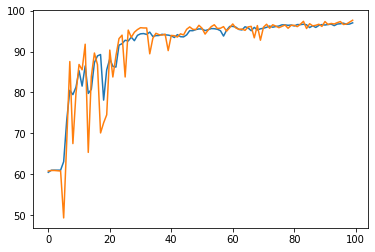

In [165]:
plt.plot(train_accuracies)
plt.plot(test_accuracies)